# Stochastic gradient descent and local optima. What is going on?


This post elaborates on the behaviour of stochastic gradient descent (SGD) when training machine learning models. Many models we train using SGD. In any ML model, once we have an objective and its gradient, then SGD would be the easiest choice. Serendipidously, we find that SGD find good parameter settings for our models. Sometimes even better than other inference algorithms. Many theories exist, but no conclusive answer has been found. 

This project leans heavily on ideas from Stefano Seatto, like [this](https://openreview.net/forum?id=HyWrIgW0W) paper and [this](https://www.youtube.com/watch?v=NFeZ6MggJjw) video. The final inspiration followed from reading the [Understanding deep learning requires rethinking generalization](https://arxiv.org/abs/1611.03530) paper. 

We will walk through one way of considering SGD. This approach is not the only one and definitely not the best one. For those who are more theoretically minded, the analysis using the Fokker Planck equation will shed more light on the problem.

By the way, this will also be my first blog post using Jupyter Notebooks. Any feedback will be greatly appreciated. Reach me at romijndersrob@gmail.com

## Stochastic surfaces rather than stochastic gradients

Another way to view SGD is to say SGD considers deterministic gradients on a family of stochastic surfaces. Traditionally, we think of the objective for an ML model as inducing a surface over all parameters. We want to find the "best" parameter, corresponding to the lowest point on this surface. The gradient would be expensive to compute, but we might get stochastic estimates on the gradient. These estimates follow from subsampling the data and calculate the gradient based on this subset of data (also named mini batch).

Actually, each mini batch of data induces its own loss surface. Rather than thinking of one loss surface, each mini batch corresponds to its own loss surface. Moreover, each data sample corresponds to a loss surface. Now the final loss surface of our problem is a mere average of all the surfaces. SGD calculates the gradient for a mini batch. In our way of viewing, SGD calculates the (deterministic) gradient on the loss surface induced by the mini batch.

These surfaces make SGD move away from some local optima. Namely, at some local optima, some of the surfaces will steep down in other directions. As long as one mini batch is hit that slopes up or down out of the local minima, then we can escape it.

To illustrate this concept, we will consider a loss surface with a local and a global minimum.

In [153]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline

In [154]:
# Manually calculate the coefficients for a polynomial with one local and one global optimum.
height_at_0 = 2.1
global_opt = 2.

# Construct a linear system with 5 unknowns, being the polynomial coefficients.
A = np.array(
    [[(global_opt)**4, (global_opt)**3, (global_opt)**2, global_opt, 1],
    [16, -8, 4, -2, 1],
    [0, 0, 0, 0, 1],
    [4*(global_opt)**3, 3*(global_opt)**2, 2*global_opt, 1, 0],
    [-32, 12, -4, 1, 0]])

b = np.array(
    [0, 2, height_at_0, 0, 0])

p = np.linalg.inv(A) @ b
print(p)



[ 0.06875  0.0625  -0.55    -0.75     2.1    ]


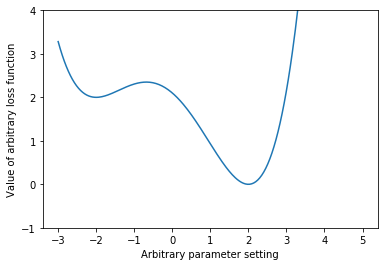

In [155]:
# Plot the corresponding curve

def f(x):
    if isinstance(x, (float, int)):
        x = np.array([[x]])
    else:
        try:
            if len(x.shape) == 1:
                x = x[:, np.newaxis]
        except:
            pass
    return np.concatenate((x**4, x**3, x**2, x, np.ones_like(x)), axis=-1) @ p

xrange = np.linspace(-3, 5, 300)

plt.plot(xrange, f(xrange))
plt.ylim([-1, 4])
plt.xlabel('Arbitrary parameter setting')
plt.ylabel('Value of arbitrary loss function');


The above plot depicts the loss function. ML models can have many thousands of parameters. So the loss function is a surface in this thousand dimensional space. Today we consider a 1D case with the loss function corresponding to a line. 

This loss surface could actually be a stochastic average of many individual surfaces. Each individual surface corresponding to one data point or one observation.

Small deviation: we think of summing contributions by data samples because of Bayes rule in logarithmic fashion. Bayes rule tells us _posterior = likelihood x prior / evidence_ which in logarithmic fashion reads as _log posterior = log likelihood + prior - evidence_. The objective is then takes as the negative log posterior, resulting in a minimization procedure.

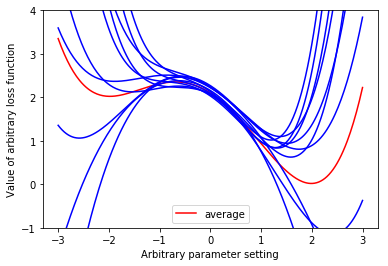

In [156]:
# plot the randomized curve
def f(x):
    if isinstance(x, (float, int)):
        x = np.array([[x]])
    else:
        try:
            if len(x.shape) == 1:
                x = x[:, np.newaxis]
        except:
            pass
    # now add the noise to the parameter value.
    return np.concatenate((x**4, x**3, x**2, x, np.ones_like(x)), axis=-1) @ (p + 0.1 * np.random.randn(5))

# Make an MC estimate of the loss surface to show it equals the original objective.
num_mc = 10000
xrange = np.linspace(-3, 3, 300)
yrange = sum((f(xrange) for _ in range(num_mc))) / num_mc

plt.plot(xrange, yrange, 'r', label='average')
for _ in range(10):  # Also plot some individual surfaces.
    plt.plot(xrange, f(xrange), 'b')
plt.ylim([-1, 4])
plt.legend()
plt.xlabel('Arbitrary parameter setting')
plt.ylabel('Value of arbitrary loss function');

Now we are ready to plot the gradients calculated with respect to each individual surface. For example, we query the point _-1.0_. The histogram depicts both the gradient of the total objective and the binned gradients of individual surfaces. The gradient is positive, meaning gradient descent would move back to the local minimum. However, the histogram shows that a portion of the samples induce a surface with negative gradient. Meaning that gradient descent would move in the direction of the global minimum. 

Text(0.5, 1.0, 'Gradient of objective 0.26250000000000007')

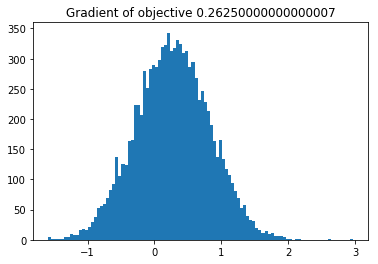

In [157]:
x_query = -1  # Which point you would like to query
derivs = np.array([4*x_query**3, 3*x_query**2, 2*x_query, 1., 0.,])

num_mc = 10000  # Number of Monte Carlo samples
grad_mc = (p+ 0.1* np.random.randn(num_mc, 5)) @ derivs

# Matplotlib magic
plt.hist(grad_mc, bins=100);
plt.title(f'Gradient of objective {p @ derivs}')

TL;DR; the gradient of the objective might point to the local minimum, the gradient induced by individual data samples might point to a global minimum

# Further reading

  * [Stefano Soatto: "Invariance and disentanglement in deep representations"
](https://www.youtube.com/watch?v=zbg49SMP5kY)
  * [Pratik Chaudhari: "Unraveling the mysteries of stochastic gradient descent on deep neural networks"
](https://www.youtube.com/watch?v=NFeZ6MggJjw)
  * [Stochastic gradient descent performs variational inference, converges to limit cycles for deep networks 
](https://openreview.net/forum?id=HyWrIgW0W)